# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [188]:
%matplotlib inline
import warnings

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

warnings.filterwarnings("ignore")
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [134]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 20000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (20000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [135]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [136]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [137]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [138]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [139]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [140]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [141]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(19354, 10)

In [142]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

96.77

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [143]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [144]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [145]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(19354, 10)


1    16339
0     3015
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [146]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
I received this box with great anticipation since they don't sell these on the west coast. I got the package, opened the box and was EXTREMELY disappointed. The cookies looked like a gorilla shook the box to death and left most of the box filled with crumbs. AND THERE WAS A RODENT SIZED HOLE ON THE SIDE OF THE BOX!!!!!!!! So, needless to say I will not NOT be reordering these again.
I have two cats. My big boy has eaten these and never had a problem...as a matter of fact he has never vomited or had a hair ball since I adopted him at 2 months. My girl cat throws up every time she eats this particular flavor. Since I treat them equally these are no longer purchased. I hate to see my girl sick so I just recommend you watch your cats after you give them these treats. If not a problem...carry on.
I was always a fan of Dave's, so I bought this at a local store to try Blair's and I'm glad I did.  The jalepeno saus

In [147]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!


In [148]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
I received this box with great anticipation since they don't sell these on the west coast. I got the package, opened the box and was EXTREMELY disappointed. The cookies looked like a gorilla shook the box to death and left most of the box filled with crumbs. AND THERE WAS A RODENT SIZED HOLE ON THE SIDE OF THE BOX!!!!!!!! So, needless to say I will not NOT be reordering these again.
I have two cats. My big boy has eaten these and never had a problem...as a matter of fact he has never vomited or had a hair ball since I adopted him at 2 months. My girl cat throws up every time she eats this particular flavor. Since I treat them equally these are no longer purchased. I hate to see my girl sick so I just recommend you watch your cats after you give them these treats. If not a problem...carry on.
I was always a fan of Dave's, so I bought this at a local store to try Blair's and I'm glad I did.  The jalepeno saus

In [149]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [150]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I have two cats. My big boy has eaten these and never had a problem...as a matter of fact he has never vomited or had a hair ball since I adopted him at 2 months. My girl cat throws up every time she eats this particular flavor. Since I treat them equally these are no longer purchased. I hate to see my girl sick so I just recommend you watch your cats after you give them these treats. If not a problem...carry on.


In [151]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

We have used the Victor fly bait for  seasons.  Can't beat it.  Great product!


In [152]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I have two cats My big boy has eaten these and never had a problem as a matter of fact he has never vomited or had a hair ball since I adopted him at 2 months My girl cat throws up every time she eats this particular flavor Since I treat them equally these are no longer purchased I hate to see my girl sick so I just recommend you watch your cats after you give them these treats If not a problem carry on 


In [153]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [154]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentence in tqdm(final['Text'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())

100%|██████████████████████████████████████████████████████████████████████████| 19354/19354 [00:07<00:00, 2517.27it/s]


In [155]:
preprocessed_reviews[1500]

'two cats big boy eaten never problem matter fact never vomited hair ball since adopted months girl cat throws every time eats particular flavor since treat equally no longer purchased hate see girl sick recommend watch cats give treats not problem carry'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [130]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [156]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaaa', 'aaaaa', 'aaaand', 'aafco', 'aahhhs', 'aahs', 'ab', 'aback', 'abandon']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (19354, 25997)
the number of unique words  25997


## [4.2] Bi-Grams and n-Grams.

In [157]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (19354, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [158]:
tf_idf_vect = TfidfVectorizer(min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'absolute', 'absolutely', 'absorb', 'absorbed', 'abundant', 'acacia', 'acai', 'accept']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (19354, 5270)
the number of unique words  5270


## [4.4] Word2Vec

In [159]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentence=[]
for sentence in preprocessed_reviews:
    list_of_sentence.append(sentence.split())

In [160]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentence,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('excellent', 0.825250506401062), ('amazing', 0.8064683079719543), ('fantastic', 0.802832841873169), ('good', 0.8007792830467224), ('awesome', 0.7828990817070007), ('wonderful', 0.7790857553482056), ('delicious', 0.6969743371009827), ('perfect', 0.6835722327232361), ('decent', 0.6547205448150635), ('super', 0.642345666885376)]
[('closest', 0.850817084312439), ('personal', 0.7927499413490295), ('hooked', 0.7918341755867004), ('ever', 0.7911834716796875), ('stunning', 0.7899191379547119), ('tim', 0.7881959080696106), ('britt', 0.7854049205780029), ('compleats', 0.7849889993667603), ('addicted', 0.7816187143325806), ('awful', 0.7811519503593445)]


In [161]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  8370
sample words  ['used', 'fly', 'bait', 'seasons', 'ca', 'not', 'beat', 'great', 'product', 'available', 'traps', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'really', 'good', 'idea', 'final', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'bought', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'stickers', 'removed', 'easily', 'daughter', 'designed', 'signs', 'printed', 'reverse', 'windows', 'beautifully']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [162]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 19354/19354 [00:26<00:00, 739.75it/s]


19354
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# [5] Assignment 11: Truncated SVD

<ol>
    <li><strong>Apply Truncated-SVD on only this feature set:</strong>
        <ul>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
    <br>
    <li><strong>Procedure:</strong>
        <ul>
    <li>Take top 2000 or 3000 features from tf-idf vectorizers using idf_ score.</li>
    <li>You need to calculate the co-occurrence matrix with the selected features (Note: X.X^T
doesn’t give the co-occurrence matrix, it returns the covariance matrix, check these
        bolgs <a href='https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285'>blog-1,</a> <a href='https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/'>blog-2 </a>for more information)</li>
            <li>You should choose the n_components in truncated svd, with maximum explained
variance. Please search on how to choose that and implement them. (hint: plot of
cumulative explained variance ratio)</li>
            <li>After you are done with the truncated svd, you can apply K-Means clustering and choose
the best number of clusters based on elbow method.</li>
            <li> Print out wordclouds for each cluster, similar to that in previous assignment. </li>
            <li>You need to write a function that takes a word and returns the most similar words using
cosine similarity between the vectors(vector: a row in the matrix after truncatedSVD)</li>
        </ul>
    </li>
    <br>
    
</ol>

## Truncated-SVD

### [5.1] Taking top features from TFIDF,<font color='red'> SET 2</font>

In [303]:
imp_features = np.take(tf_idf_vect.get_feature_names(), np.argsort(tf_idf_vect.idf_)[-3000:][::-1])
print("Some important features:")
print(imp_features[:20])

Some important features:
['grated' 'charm' 'claiming' 'citric' 'glossy' 'microwaveable' 'chosen'
 'pasty' 'pat' 'twists' 'meyenberg' 'godiva' 'unappealing' 'grades'
 'chefs' 'unbelievably' 'unbroken' 'merely' 'undamaged' 'cheez']


### [5.2] Calculation of Co-occurrence matrix

In [363]:
## https://datascience.stackexchange.com/questions/40038/how-to-implement-word-to-word-co-occurence-matrix-in-python
from collections import Counter

# Initialize a Counter with keys as imp features, and values as a Counter having 0 count for each of the 3000 imp features
X = {ii:Counter({jj:0 for jj in imp_features}) for ii in imp_features}

# Set context length to 3 words(on both sides each of any word in corpus)
k=3

for sen in tqdm(list_of_sentence):
    for ii in range(len(sen)):
        # If word being being searched in context is in the starting k indices of the list
        if ii < k:
            # Create Counter for all k words to the left of the k+1 th index
            c = Counter(sen[0:ii+k+1])
            # Delete count of word which is same as the word being searched in context
            del c[sen[ii]]
            # If word is in the list of imp words 
            if sen[ii] in X.keys():
                # Add count for each word occuring in same context
                X[sen[ii]].update(c)
        # If word being being searched in context is in the ending k indices of the list
        elif ii > len(sen)-(k+1):
            # Create counter for all words to the right of the k th index and add to the main counter
            c = Counter(sen[ii-k:])
            del c[sen[ii]]
            if sen[ii] in X.keys():
                X[sen[ii]].update(c)
        # For all other middle placed indices
        else:
            c = Counter(sen[ii-k:ii+k+1])
            del c[sen[ii]]
            if sen[ii] in X.keys():
                X[sen[ii]].update(c)

# Having final matrix in dict form lets you convert it to different python data structures
X = {ii:dict(X[ii]) for ii in imp_features}

# Convert to Dataframe for display
df_X = pd.DataFrame(X, index=X.keys(), columns=X.keys())
df_X

100%|██████████████████████████████████████████████████████████████████████████| 19354/19354 [00:04<00:00, 4779.74it/s]


,grated,charm,claiming,citric,glossy,microwaveable,chosen,pasty,pat,twists,...,attempt,computer,acerola,mart,stored,sticking,palate,concentrates,powerful,attractive
grated,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
charm,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
claiming,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
citric,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
glossy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
microwaveable,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chosen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pasty,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
pat,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
twists,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [362]:
print("Words which are related to hydrogenated and how often they occur in the same context:")
print("="*100)
print(df_X[df_X['hydrogenated'] != 0]['hydrogenated'])

Words which are related to hydrogenated and how often they occur in the same context:
enriched         1
hydrated         1
commonly         1
butters          1
laugh            1
maltodextrin     1
spiciness        1
kernel           1
thankful         1
soybean          4
indicate         1
whey             1
aspartame        1
canola           2
chowder          2
manufacturers    1
thicken          1
acids            2
Name: hydrogenated, dtype: int64


### [5.3] Finding optimal value for number of components (n) to be retained.

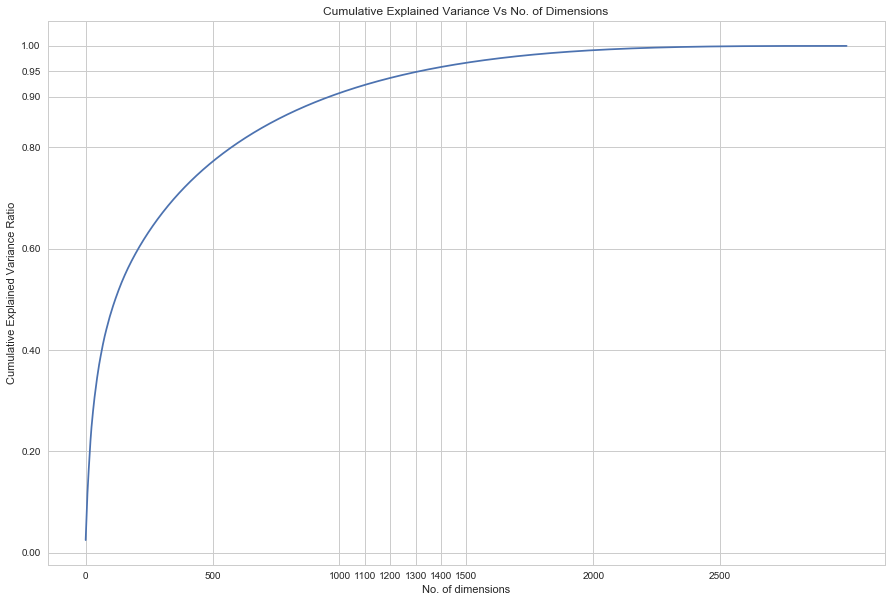

In [306]:
from sklearn.decomposition import TruncatedSVD
from scipy import sparse
# Storing Co-Occurence matrix as a sparse CSR matrix
X = sparse.csr_matrix(df_X.values)
svd = TruncatedSVD(n_components=2999, random_state=0)
svd.fit(X)
plt.figure(figsize=(15, 10))
plt.style.use('seaborn-whitegrid')
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('No. of dimensions')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.xticks([0, 500, 1000, 1100, 1200, 1300, 1400, 1500, 2000, 2500])
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 1.0])
plt.title('Cumulative Explained Variance Vs No. of Dimensions')
plt.show()

From the above plot of Cumulative Explained Variance Vs No.of Components, we find that 1300 dimensions out of the 3000 are enough to explain 95% of the Total Explained Variance for each dimension. Hence, out of the 3000 dimensions of the co-occurrence matrix, we will be keeping only 1300 dimensions.

### [5.4] Applying k-means clustering

Shape after reducing dimensions:  (3000, 1300)


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.43s/it]


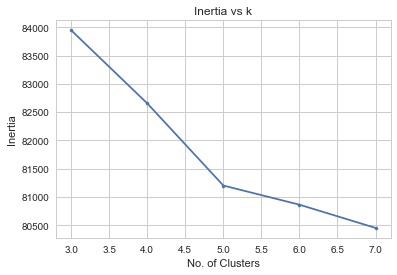

In [307]:
# Reduce dimensions from 3000 to 1300 using Truncated-SVD
tsvd = TruncatedSVD(n_components= 1300, random_state=0)
X_reduced = tsvd.fit_transform(X)
print("Shape after reducing dimensions: ", X_reduced.shape)

# Applying k-Means on the reduced dimesions co-occurrence matrix
k_range = np.arange(3,8)
inertia = []
for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, random_state=0, n_jobs=-1)
    kmeans.fit(X_reduced)
    inertia.append(kmeans.inertia_)

# plt.style.use('seaborn-white')
plt.grid('on')
plt.plot(k_range, inertia, marker='.')
plt.xlabel('No. of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia vs k')
plt.show()

In [308]:
# Applying k-Means with optimal no.of 5 clusters
clusters = KMeans(n_clusters=5, random_state=0, n_jobs=-1).fit_predict(X_reduced)

### [5.5] Wordclouds of clusters obtained in the above section

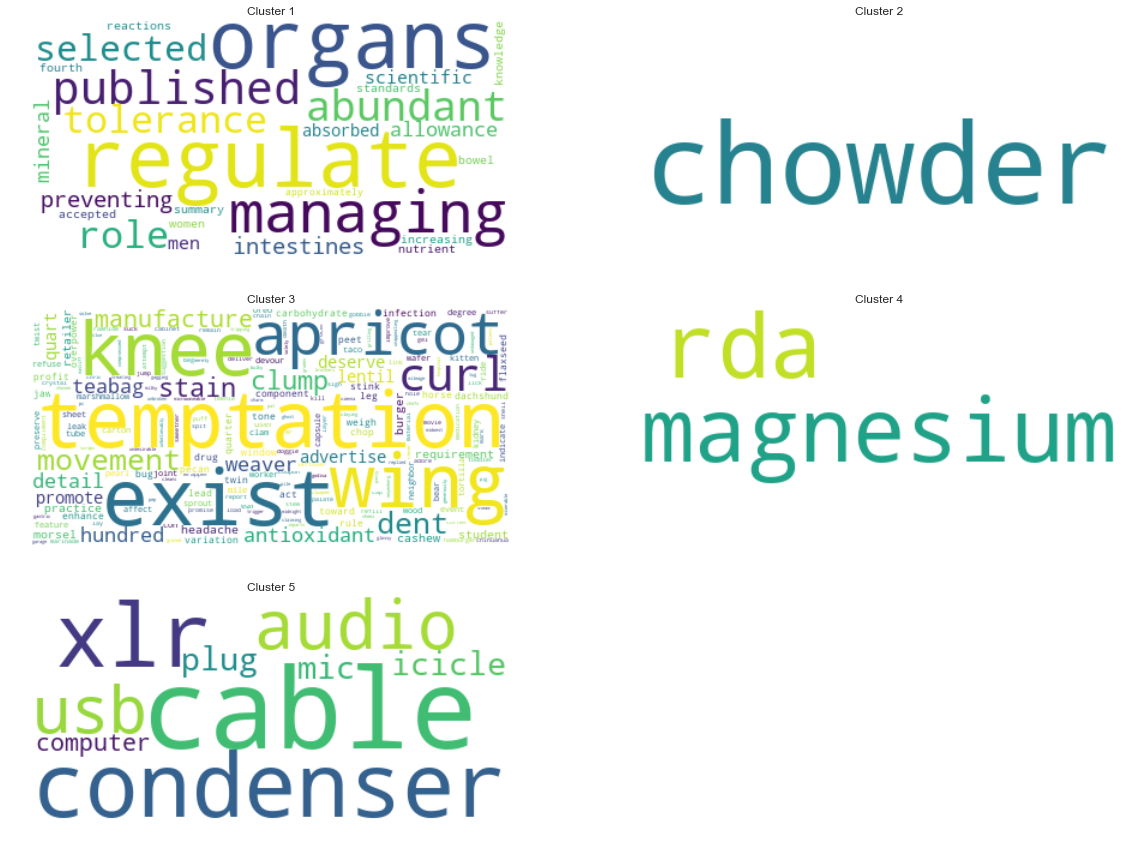

In [309]:
from wordcloud import WordCloud
imp_features = list(imp_features)
plt.figure(figsize=(20, 15))
for i in range(5):
    words = [imp_features[j] for j in np.where(clusters == i)[0]]
    plt.subplot(3, 2, i+1)
    # Plot the Wordcloud
    wordcloud = WordCloud(background_color="white").generate(" ".join(words))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
#     plt.tight_layout()
    plt.title('Cluster ' + str(i+1))
plt.show()

### [5.6] Function that returns most similar words for a given word.

In [364]:
# Cosine similarity of vectors A & B is given by A.B/|A|*|B|
def getSimilarWords(word, n=10):
    if word not in imp_features:
        print("Given word is not in the list of %d important features."%len(imp_features))
    else:
        n = min(n, X_reduced.shape[0]) # To make sure n doesn't exceed no. of imp. features
        word_vec = X_reduced[imp_features.index(word), :] # Fetching the vector for the queried word
        cos_sim = np.zeros(X_reduced.shape[0]) # Initializing an array to store cosine similarities
        for i in range(X_reduced.shape[0]):
            vec_i = X_reduced[i, :] # Fetch vector for each word in matrix
            # Compute Cosine similarity with each vector and store in array
            cos_sim[i] = np.dot(vec_i, word_vec)/(np.linalg.norm(vec_i) * np.linalg.norm(word_vec))
        print("%d words most similar to %s(in context of Amazon food reviews only):"%(n, word))
        print("="*100)
        # Print excluding the queried word
        print(np.take(imp_features, np.argsort(-cos_sim)[1:n]))

In [365]:
getSimilarWords('computer', 20)

20 words most similar to computer(in context of Amazon food reviews only):
['cable' 'xlr' 'plug' 'icicle' 'audio' 'usb' 'phantom' 'pc' 'mic'
 'condenser' 'recording' 'driver' 'route' 'noise' 'performance' 'losing'
 'device' 'haha' 'windows']


# [6] Conclusions

<ul>
    <li>
        The Co-Occurrence matrix, which was computed from 3000 most important features selected on the basis of TFIDF score, 
        was a sparse matrix, as most elements were zero. The non-zero elements showed which words were used in the same context 
        within the reviews which were selected for this exercise.
    </li>
    <li>
        This matrix represented 3000 vectors of 3000 dimensions each. To reduce the dimensions of these vectors without losing 
        much information, Truncated SVD was used on this co-occurrence matrix. The cumulative Explained Variance Ratio was 
        plotted against the number of dimensions, making it quite clear that only 1300 dimessions out of these 3000 account for 
        about 95% of the explained variance. Hence, the co-occurrence matrix was decomposed into a matrix with 1300 dimensions 
        for each word vector.
    </li>
    <li>
        k-Means was used to cluster these features. To get an optimal value of the no. of cluster centroids k, we plotted the 
        inertia(Sum of squared distances of samples to their closest cluster center) Vs k, and observed that k=5 seemed like 
        the best no. of clusters.
    </li>
    <li>
        On applying k-Means with 5 as the no. of clusters and plotting the resulting clusters as wordclouds, we see that 3 out 
        of the 5 clusters do contain related terms within the same cluster. Although the 3rd cluster, containing most number of 
        words is incomprehensible in terms of similarity of words grouped and the 2nd cluster contains only one word, the 1st, 
        4th and 5th clusters do make sense.
    </li>
    <li>
        We can see that the 1st cluster deals with possibly the role of minerals in regulating intestines and other organs in 
        both men and women, mentions some published scientific research about this and talks of tolerance and reactions to 
        their intake. Similarly, the 3rd cluster groups the words - rda and magnesium, which are very much related -        
        Magnesium, the mineral has some RDA(recommended daily allowance). On the other hand, the last cluster groups some audio 
        equipment which are used in conjunction with a computer. XLR and USB are both interfaces used for audio applications, 
        Condenser is a type of microphone, and Icicle is a brand which sells XLR to USB Mic converter.
    </li>
    <li>
        Finally, we use the co-occurrence matrix to find words which are simiilar to a given word in terms of the context in 
        which they have been used in the reviews dataset. It produces mixed results, but does give us an idea of which terms 
        have similar context in the reviews data.
    </li>
</ul>

In [367]:
# Please write down few lines about what you observed from this assignment. 
# Also please do mention the optimal values that you obtained for number of components & number of clusters.
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Step", "Algorithm", "No. of Dimensions/Clusters"]
x.add_row(["Dimensionality Reduction", "Truncated SVD", "1300 dimensions"])
x.add_row(["Clustering", "k-Means", "5 clusters"])
print(x)


+--------------------------+---------------+----------------------------+
|           Step           |   Algorithm   | No. of Dimensions/Clusters |
+--------------------------+---------------+----------------------------+
| Dimensionality Reduction | Truncated SVD |      1300 dimensions       |
|        Clustering        |    k-Means    |         5 clusters         |
+--------------------------+---------------+----------------------------+
